In [41]:
import itertools

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import pandas as pd
from scipy import stats as st
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

from IPython.display import HTML

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
from evaluate_encoder import evaluate_subject
import util

In [26]:
subject = "M02"
models = ["SQuAD", "SST", "QQP", "MNLI", "LM_scrambled", "LM_pos"]
runs = [1, 2]
layers = [2, 5, 8, 9, 10, 11]

n_filter = 250

In [43]:
all_errors, thresholded_errors = evaluate_subject(subject, models, runs, layers, downsample=3, threshold=n_filter)

Models: 100%|██████████| 6/6 [00:00<00:00, 27.78it/s]


## `matplotlib` helpers

In [36]:
def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt(positions, sizes=None, colors=None, alpha=None, edgecolors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data(p, size=s) )
        
    pc = Poly3DCollection(np.concatenate(g), **kwargs)
    if alpha is not None:
        pc.set_alpha(alpha)
    if edgecolors is not None:
        pc.set_edgecolors(edgecolors)
    pc.set_facecolors(np.repeat(colors, 6, axis=0))
    return pc

## Animation

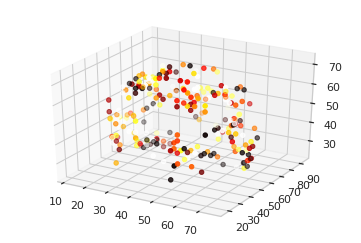

In [44]:
animate_model = "QQP"
errors_filtered, coords_filtered = thresholded_errors[animate_model]

def render_errors(layer_idx):
    cmap = plt.get_cmap("hot")
    ax.clear()
    ax.scatter(coords_filtered[:, 0], coords_filtered[:, 1], coords_filtered[:, 2], c=errors_filtered[layer_idx], cmap=cmap)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim((0, coords_filtered[:, 0].max()))
ax.set_ylim((0, coords_filtered[:, 1].max()))
ax.set_zlim((0, coords_filtered[:, 2].max()))
graph = ax.scatter(*np.tile(0, (3, n_filter)))
ani = FuncAnimation(fig, render_errors, 4, interval=200, blit=False, repeat=False)
HTML(ani.to_html5_video())

## Full grid

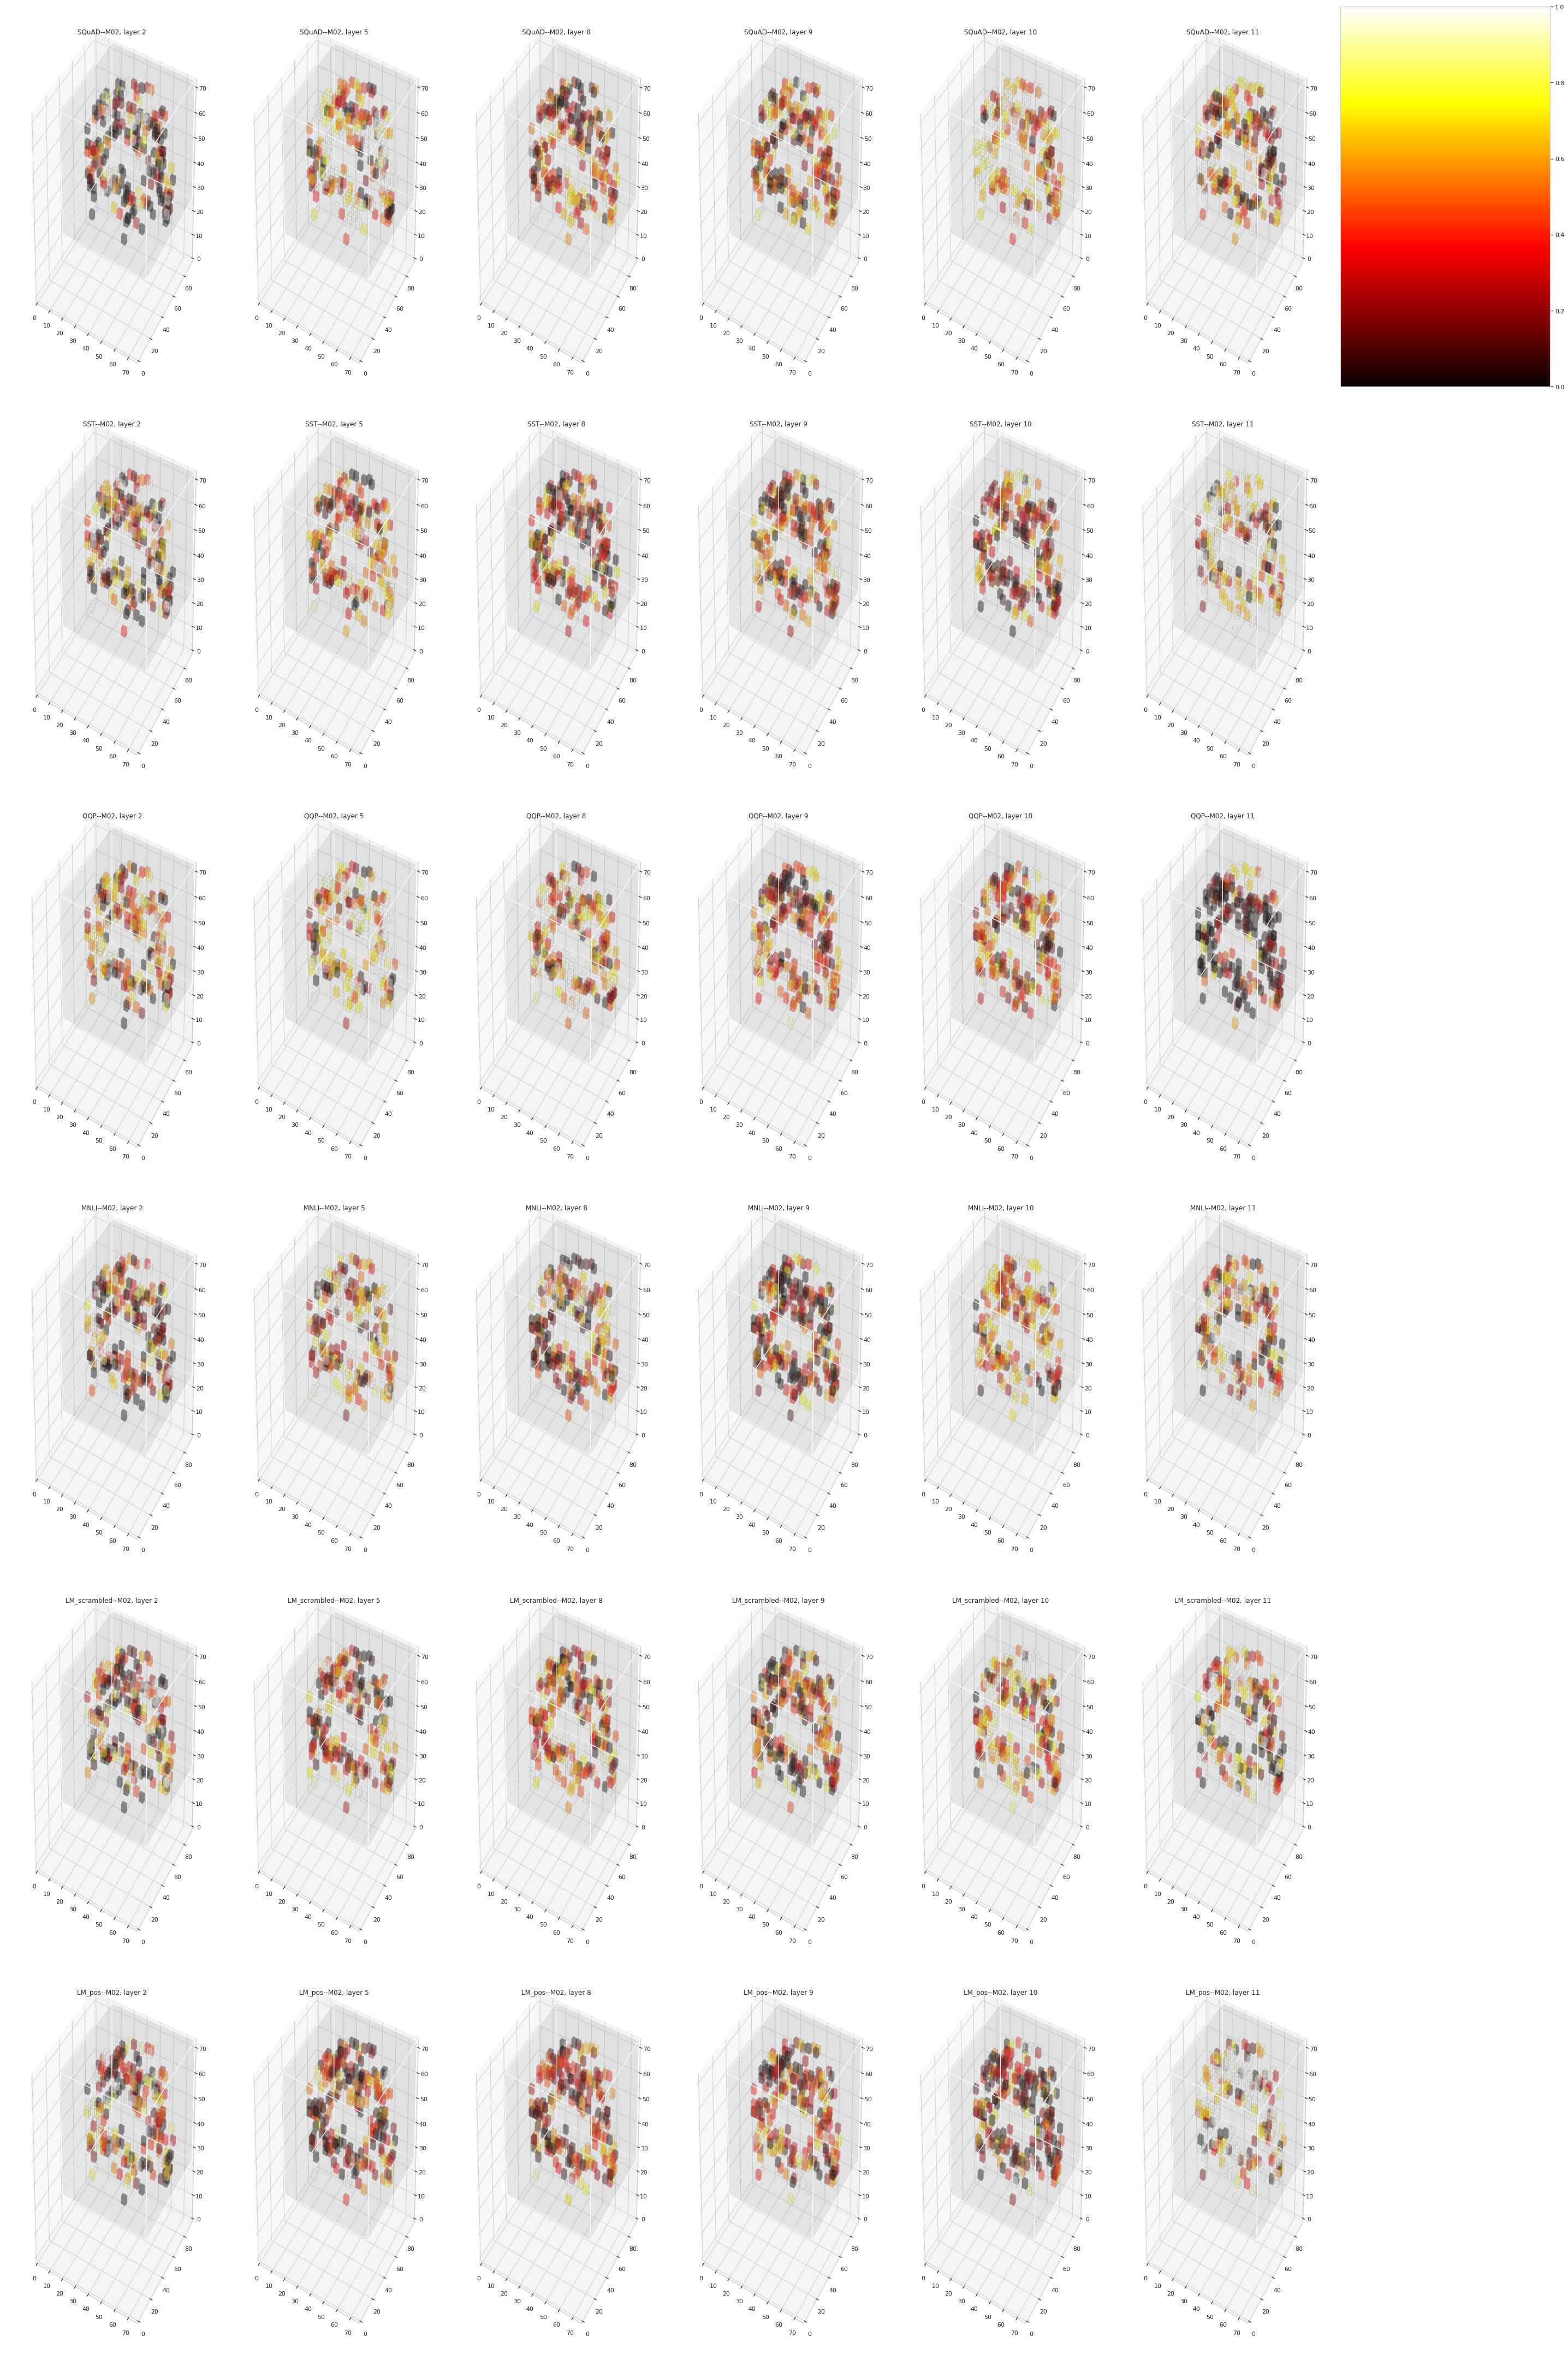

In [38]:
n_rows = len(models)
n_cols = len(layers) + 1
fig = plt.figure(figsize=(40, 10 * n_rows))
cmap = plt.get_cmap("hot")

def plot_cube(cube_definition):
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]

    faces = Poly3DCollection(edges, alpha=0.075)
    faces.set_facecolor("gray")
    return faces


# compute corner of containing cube
corner = coords.min(axis=0)
corner0 = np.array((corner[0] + coords[:, 0].max() - coords[:, 0].min(), corner[1], corner[2]))
corner1 = np.array((corner[0], corner[1] + coords[:, 1].max() - coords[:, 1].min(), corner[2]))
corner2 = np.array((corner[0], corner[1], corner[2] + coords[:, 2].max() - coords[:, 2].min()))


for model_idx, model in enumerate(models):
    for layer_idx, layer in enumerate(layers):
        errors_filtered, coords_filtered = thresholded_errors[model]
        
        ax = fig.add_subplot(n_rows, n_cols, 1 + layer_idx + model_idx * n_cols, projection="3d")
        ax.set_xlim((0, coords_filtered[:, 0].max()))
        ax.set_ylim((0, coords_filtered[:, 1].max()))
        ax.set_zlim((0, coords_filtered[:, 2].max()))
        
        # Plot containing cube.
        ax.add_collection3d(plot_cube([corner, corner0, corner1, corner2]))
        
        poly_collection = plotCubeAt(coords_filtered,
                                     sizes=np.tile([(3, 3, 3)], (len(coords_filtered), 1)),
                                     colors=[cmap(v) for v in errors_filtered[layer_idx]],
                                     linewidths=0.5, edgecolors="gray", alpha=0.25)
        ax.add_collection3d(poly_collection)

        ax.set_title("%s--%s, layer %d" % (model, subject, layer))
    
ax = fig.add_subplot(n_rows, n_cols, len(layers) + 1)
from matplotlib.colorbar import ColorbarBase
ColorbarBase(ax, cmap=cmap)
plt.tight_layout()

## Overlap analysis

For a low error threshold (say, the 50 best super-voxels), how much overlap is there between models?

In [45]:
n_threshold = 200

In [46]:
m_keys = sorted(models)
overlap_df = pd.DataFrame(columns=m_keys, index=m_keys)
for model1, model2 in itertools.combinations(m_keys, 2):
    errors1, errors2 = all_errors[model1], all_errors[model2]
    order1 = errors1.min(axis=0).argsort()[:n_threshold]
    order2 = errors2.min(axis=0).argsort()[:n_threshold]
    
    coords1 = coords[order1]
    coords1 = set([tuple(coords_i) for coords_i in coords1])
    coords2 = coords[order2]
    coords2 = set([tuple(coords_i) for coords_i in coords2])
    
    overlap_df.loc[model1][model2] = len(coords1 & coords2)

overlap_df
#sns.heatmap(overlap_df.fillna(0))

LM_pos LM_scrambled MNLI  QQP SQuAD  SST
LM_pos          NaN          194  194  193   191  191
LM_scrambled    NaN          NaN  195  193   192  191
MNLI            NaN          NaN  NaN  194   192  192
QQP             NaN          NaN  NaN  NaN   191  192
SQuAD           NaN          NaN  NaN  NaN   NaN  192
SST             NaN          NaN  NaN  NaN   NaN  NaN